# Étape 1: Préparation et Exploration des Données

(84864, 5)


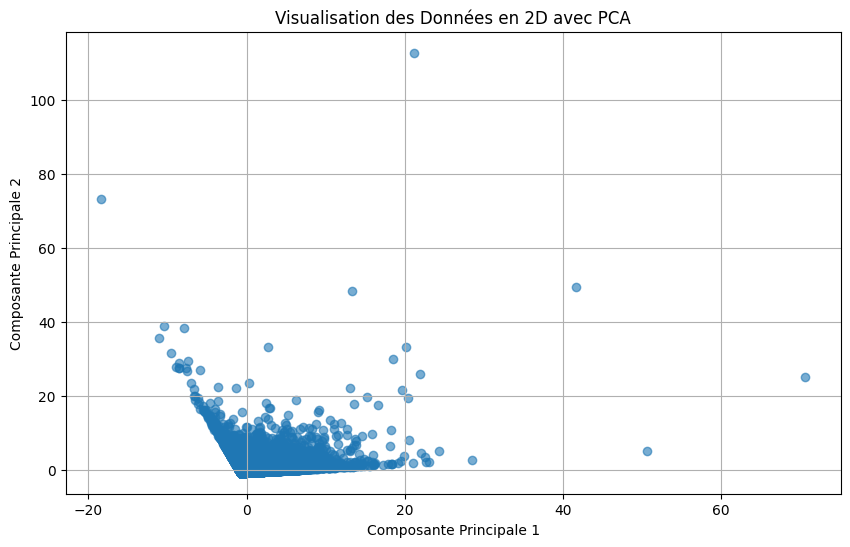

In [1]:
# Importation des librairies nécessaires
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Chargement des données
df = pd.read_parquet("data/user_stats_df_output.parquet")

# Création de nouvelles variables si elles n'existent pas
if 'loyalty_score' not in df.columns:
    df['loyalty_score'] = df['total_purchase_value'] / (df['number_of_sessions_7m'] + 1)

if 'conversion_rate' not in df.columns:
    df['conversion_rate'] = df['total_purchase_value'] / (df['number_of_sessions_7m'] + 1)

# Sélectionner les variables pour le clustering
variables_pour_clustering = [
    'number_of_views_7m',
    'number_of_sessions_7m',
    'total_purchase_value',
    'loyalty_score',
    'conversion_rate'
]

# Filtrage des données et suppression des valeurs manquantes
X = df[variables_pour_clustering].dropna()

# # Vérification de la taille des données
# print(X.shape)

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Réduction de dimension pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualisation des données en 2D
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.title('Visualisation des Données en 2D avec PCA')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.grid(True)
plt.show()


# Étape 2: Recherche des Paramètres Optimaux pour DBSCAN

In [2]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import gc

# Limiter l'échantillon pour éviter les crashs
sample_size = min(10000, len(X_scaled))
X_sample = X_scaled[:sample_size]

# Affiner les valeurs de `eps` et `min_samples`
eps_values = [0.6 + 0.01 * i for i in range(0, 10)]  # Tester de 0.6 à 0.7
min_samples_values = [3, 4, 5, 6]

best_score = -1
best_eps = None
best_min_samples = None

# Tester différentes combinaisons de paramètres
for eps in eps_values:
    for min_samples in min_samples_values:
        try:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            clusters = dbscan.fit_predict(X_sample)
            num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
            num_noise = list(clusters).count(-1)
            print(f"eps: {eps:.3f}, min_samples: {min_samples}, clusters: {num_clusters}, noise points: {num_noise}")

            # Calcul du score silhouette si au moins 2 clusters sont trouvés
            if num_clusters > 1:
                score = silhouette_score(X_sample[clusters != -1], clusters[clusters != -1])
                print(f"Silhouette Score: {score:.2f}")

                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples

            gc.collect()

        except Exception as e:
            print(f"Erreur avec eps={eps}, min_samples={min_samples}: {e}")

# Affichage des meilleurs paramètres
print(f"Meilleur eps: {best_eps}, Meilleur min_samples: {best_min_samples}, Meilleur Score Silhouette: {best_score:.2f}")


eps: 0.600, min_samples: 3, clusters: 16, noise points: 153
Silhouette Score: 0.57
eps: 0.600, min_samples: 4, clusters: 5, noise points: 206
Silhouette Score: 0.62
eps: 0.600, min_samples: 5, clusters: 3, noise points: 222
Silhouette Score: 0.63
eps: 0.600, min_samples: 6, clusters: 2, noise points: 238
Silhouette Score: 0.68
eps: 0.610, min_samples: 3, clusters: 14, noise points: 153
Silhouette Score: 0.57
eps: 0.610, min_samples: 4, clusters: 5, noise points: 199
Silhouette Score: 0.62
eps: 0.610, min_samples: 5, clusters: 3, noise points: 219
Silhouette Score: 0.63
eps: 0.610, min_samples: 6, clusters: 2, noise points: 235
Silhouette Score: 0.68
eps: 0.620, min_samples: 3, clusters: 14, noise points: 149
Silhouette Score: 0.57
eps: 0.620, min_samples: 4, clusters: 3, noise points: 198
Silhouette Score: 0.63
eps: 0.620, min_samples: 5, clusters: 3, noise points: 215
Silhouette Score: 0.63
eps: 0.620, min_samples: 6, clusters: 2, noise points: 229
Silhouette Score: 0.69
eps: 0.630, m

# Étape 3: Application de DBSCAN avec les Meilleurs Paramètres


Application de DBSCAN avec eps=0.62 et min_samples=6
Nombre de clusters détectés: 2, points de bruit: 229


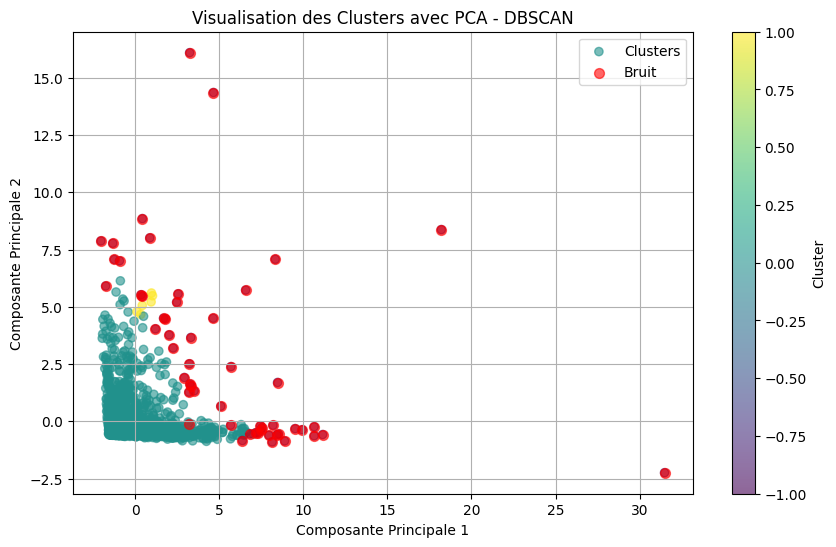

In [3]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import gc
import numpy as np

# Assurez-vous que les meilleurs paramètres ont été trouvés avant d'exécuter cette partie
if best_eps is None or best_min_samples is None:
    print("Paramètres DBSCAN non trouvés, veuillez ajuster les plages d'eps et min_samples.")
else:
    try:
        # Application de DBSCAN avec les meilleurs paramètres trouvés
        print(f"Application de DBSCAN avec eps={best_eps} et min_samples={best_min_samples}")

        # Utilisation d'un sous-échantillon pour DBSCAN si le jeu de données est trop volumineux
        subsample_size = min(10000, len(X_scaled))  # Ajustez ce nombre selon la mémoire disponible
        X_dbscan_sample = X_scaled[:subsample_size]  # Utiliser un sous-échantillon pour éviter les calculs lourds
        
        # Appliquer DBSCAN sur un échantillon pour vérifier le comportement avant l'ensemble complet
        dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
        clusters = dbscan.fit_predict(X_dbscan_sample)
        
        # Nombre de clusters sans compter le bruit
        num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        num_noise = list(clusters).count(-1)
        print(f"Nombre de clusters détectés: {num_clusters}, points de bruit: {num_noise}")

        # Réduire la taille pour la visualisation afin d'éviter le blocage
        visual_sample_size = min(2000, len(X_dbscan_sample))
        X_pca = PCA(n_components=2).fit_transform(X_dbscan_sample[:visual_sample_size])
        clusters_sample = clusters[:visual_sample_size]

        # Visualisation des clusters avec PCA
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_sample, cmap='viridis', alpha=0.6, label='Clusters')
        plt.scatter(X_pca[clusters_sample == -1, 0], X_pca[clusters_sample == -1, 1], 
                    c='red', s=50, alpha=0.6, label='Bruit')
        plt.title('Visualisation des Clusters avec PCA - DBSCAN')
        plt.xlabel('Composante Principale 1')
        plt.ylabel('Composante Principale 2')
        plt.colorbar(scatter, label='Cluster')
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Erreur lors de l'application de DBSCAN et de la visualisation : {e}")

    finally:
        # Nettoyer la mémoire après l'exécution
        gc.collect()


# Étape 4: Filtrage des Outliers avec Isolation Forest

In [7]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

####### A enlever quand on joue tout le processus
# Chargement des données
df = pd.read_parquet("data/user_stats_df_output.parquet")

# Création de nouvelles variables si elles n'existent pas
if 'loyalty_score' not in df.columns:
    df['loyalty_score'] = df['total_purchase_value'] / (df['number_of_sessions_7m'] + 1)

if 'conversion_rate' not in df.columns:
    df['conversion_rate'] = df['total_purchase_value'] / (df['number_of_sessions_7m'] + 1)

# Sélectionner les variables pour le clustering
variables_pour_clustering = [
    'number_of_views_7m',
    'number_of_sessions_7m',
    'total_purchase_value',
    'loyalty_score',
    'conversion_rate'
]

# Filtrage des données et suppression des valeurs manquantes
X = df[variables_pour_clustering].dropna()


# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
###################################

# Appliquer Isolation Forest pour détecter les outliers
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = isolation_forest.fit_predict(X_scaled)

# Garder uniquement les points normaux (label 1) et filtrer les outliers (label -1)
X_filtered = X_scaled[outliers == 1]

# Affichage du nombre de points conservés
print(f"Nombre de points après filtrage des outliers : {len(X_filtered)} sur {len(X_scaled)}")


Nombre de points après filtrage des outliers : 80620 sur 84864


Étape 5 : Ré-appliquer DBSCAN sur les Données Filtrées


Nombre de clusters après filtrage : 1, points de bruit : 4


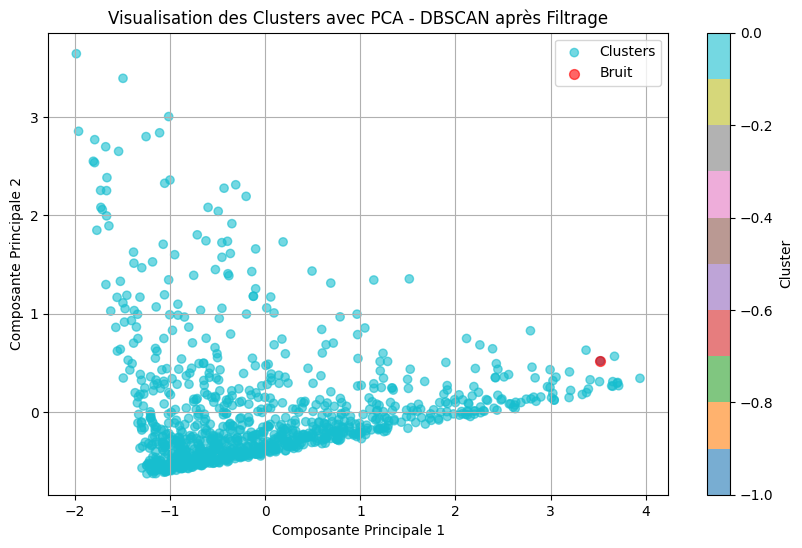

6147

In [8]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import gc

# Appliquer DBSCAN sur un échantillon des données filtrées si la taille totale est trop grande
sample_size = min(5000, len(X_filtered))  # Limiter à 5000 points pour éviter les crashs
X_sample_filtered = X_filtered[:sample_size]

# Réduire la taille du jeu de données pendant l'application de DBSCAN
try:
    dbscan = DBSCAN(eps=0.62, min_samples=5)  # Utiliser les meilleurs paramètres précédemment trouvés
    clusters = dbscan.fit_predict(X_sample_filtered)

    # Compter le nombre de clusters et de points de bruit après filtrage
    num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    num_noise = list(clusters).count(-1)
    print(f"Nombre de clusters après filtrage : {num_clusters}, points de bruit : {num_noise}")

    # Visualisation des clusters avec PCA
    visual_sample_size = min(1000, len(X_sample_filtered))  # Réduire encore pour la visualisation
    X_pca = PCA(n_components=2).fit_transform(X_sample_filtered[:visual_sample_size])
    clusters_sample = clusters[:visual_sample_size]

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_sample, cmap='tab10', alpha=0.6, label='Clusters')
    plt.scatter(X_pca[clusters_sample == -1, 0], X_pca[clusters_sample == -1, 1], c='red', s=50, alpha=0.6, label='Bruit')
    plt.title('Visualisation des Clusters avec PCA - DBSCAN après Filtrage')
    plt.xlabel('Composante Principale 1')
    plt.ylabel('Composante Principale 2')
    plt.colorbar(scatter, label='Cluster')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Erreur lors de l'application de DBSCAN et de la visualisation : {e}")

# Nettoyer la mémoire après l'exécution
gc.collect()



# DBSCAN et l'utilisation de t-SNE pour une meilleure visualisation :

Nombre de clusters détectés dans l'échantillon : 1


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


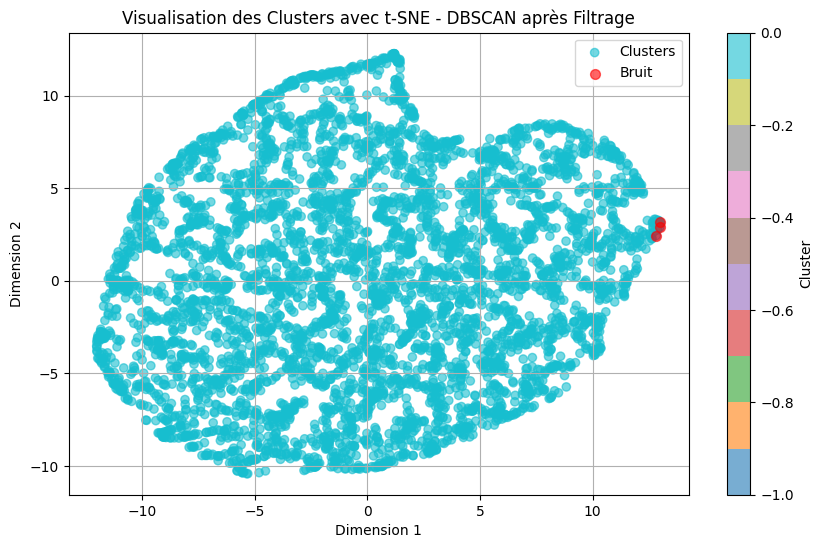

6228

In [9]:


from sklearn.manifold import TSNE



# Paramètres DBSCAN
best_eps = 0.65
best_min_samples = 5

# Réduire la taille des données pour tester DBSCAN
sample_size = min(5000, len(X_filtered))  # Limiter à 5000 points pour éviter le blocage
X_sample = X_filtered[:sample_size]

# Application de DBSCAN sur l'échantillon réduit
try:
    # Appliquer DBSCAN sur un sous-échantillon
    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, n_jobs=-1)
    clusters_sample = dbscan.fit_predict(X_sample)

    # Compter le nombre de clusters détectés (excluant le bruit)
    num_clusters = len(set(clusters_sample)) - (1 if -1 in clusters_sample else 0)
    print(f"Nombre de clusters détectés dans l'échantillon : {num_clusters}")

    # Réduction de dimension avec t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    X_tsne = tsne.fit_transform(X_sample)

    # Visualisation avec t-SNE
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters_sample, cmap='tab10', alpha=0.6, label='Clusters')
    plt.scatter(X_tsne[clusters_sample == -1, 0], X_tsne[clusters_sample == -1, 1], c='red', s=50, alpha=0.6, label='Bruit')
    plt.title('Visualisation des Clusters avec t-SNE - DBSCAN après Filtrage')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.colorbar(scatter, label='Cluster')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Erreur lors de l'application de DBSCAN : {e}")

# Nettoyage de la mémoire après l'exécution
gc.collect()



